In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from collections import OrderedDict
import sys, os
from prisk.asset import PowerPlant, WareHouse, Manufacturing
from prisk.flood import FloodExposure, FloodEntitySim, FloodExceedanceCurve
from prisk.firm import Holding
from prisk.portfolio import Portfolio
from prisk.kernel import Kernel
from prisk.insurance import Insurance
# === AUTO-RELOAD SETUP ===
# This will automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# This tells Jupyter to automatically reload any imported modules
# when their source code changes
print("Auto-reload enabled - modules will update automatically")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Auto-reload enabled - modules will update automatically


In [343]:
# Load CSVs
thailand_assets = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\synthetic_assets_thailand_flooded_point.csv")
financial_data = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\synthetic_owners_thailand.csv")
# Make RP columns int not str1
thailand_assets.columns = thailand_assets.columns.map(lambda c: int(c) if str(c).isdigit() else c)
# Temp (going to just start by running on power assets) - so filter by asset class
# thailand_assets = thailand_assets[thailand_assets['asset_class']=='power']

In [344]:
leverage_ratios = {firm: leverage for firm, leverage in zip(financial_data["owner_name"], financial_data["leverage_ratio"])}
damage_curves = pd.read_excel("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/damage_curves.xlsx")
return_period_columns = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

In [345]:
def extract_firms(assets, damage_curves=None, leverage_ratios={}, discount_rate=0.05, time_horizon=25):
    assets.sort_values("owner_name", inplace=True)
    if damage_curves is None:
        damage_curves = continuous_curves
    # Create assets for each asset type
    # Starting with power assets
    power_assets = assets[assets['asset_class']=='power'].copy()
    # Power specific variables
    power_unit_price = 60 # pounds per MWh
    power_margin = 0.2 # 20% profit margin for electricity generation
    power_assets.loc[:, "asset"] = power_assets.apply(lambda x: 
                                                PowerPlant(
                                                    name=x["asset_name"],
                                                    flood_damage_curve=damage_curves,
                                                    flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0],
                                                    flood_protection = x["flood_protection"],
                                                    production_path=np.repeat(x["size"]*24*365, time_horizon),
                                                    replacement_cost=x["asset_value_usd"],
                                                    unit_price=power_unit_price,
                                                    discount_rate=discount_rate,
                                                    margin=power_margin,
                                                  ), axis=1)
    # Warehouse
    warehouse_assets = assets[assets['asset_class']=='warehouse'].copy()
    # Warehouse specific variables
    warehouse_unit_price = 100 # pounds p.a. rental income
    warehouse_margin = 0.09 # 9% profit margin of warehouse facilities
    warehouse_assets.loc[:, "asset"] = warehouse_assets.apply(lambda x: 
                                                    WareHouse(
                                                        name=x["asset_name"],
                                                        flood_damage_curve=damage_curves,
                                                        flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                        for return_period in return_period_columns if x[return_period] > 0],
                                                        flood_protection = x["flood_protection"],
                                                        production_path=np.repeat(x["size"], time_horizon),
                                                        replacement_cost=x["asset_value_usd"],
                                                        unit_price=warehouse_unit_price,
                                                        discount_rate=discount_rate,
                                                        margin=warehouse_margin,
                                                      ), axis=1)
    # Manufacturing facility
    manufacturing_assets = assets[assets['asset_class']=='manufacturing'].copy()
    # Manufacturing specific variables
    manufacturing_unit_price = 2500 # pounds p.a. production per m^2
    manufacturing_margin = 0.07 # 7% profit margin
    manufacturing_assets.loc[:, "asset"] = manufacturing_assets.apply(lambda x: 
                                                    Manufacturing(
                                                    name=x["asset_name"],
                                                    flood_damage_curve=damage_curves,
                                                    flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0],
                                                    flood_protection = x["flood_protection"],
                                                    production_path=np.repeat(x["size"], time_horizon),
                                                    replacement_cost=x["asset_value_usd"],
                                                    unit_price=manufacturing_unit_price,
                                                    discount_rate=discount_rate,
                                                    margin=manufacturing_margin,
                                                  ), axis=1)
    # Combine these back together
    assets = pd.concat(
        [power_assets, warehouse_assets, manufacturing_assets],
        axis=0,
        ignore_index=True
    )
    
    list_of_owners = []
    for owners in assets["owner_name"].unique():
        if pd.isna(owners):
            continue
        list_of_owners.append(owners)
    list_of_owners = list(OrderedDict.fromkeys(list_of_owners))
    owner_map = {owner: Holding(owner, leverage_ratio=leverage_ratios.get(owner)) for owner in list_of_owners}
    holdings = []
    for i, owner in enumerate(assets["owner_name"]):
        if pd.isna(owner):
            continue
        share = 100 # here assuming each asset only has 1 owner. In original PRISK there could be a multi-ownership structure
        holding = owner_map[owner]
        holding.add_asset(assets.loc[i, "asset"], share)
        holdings.append(holding)
    return list(OrderedDict.fromkeys(holdings)), assets
    
def convert_to_continous_damage(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max((damage_curves["depth"] + 0.01)*100)))})
    continuous_curves["index"] = continuous_curves["index"]/100
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="depth")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("depth", inplace=True)
    return continuous_curves

def merton_probability_of_default(V, sigma_V, D, r=0, T=1):
    """
    Calculate the probability of default using the Merton model.

    Parameters:
    V (float): Current value of the company's assets.
    sigma_V (float): Volatility of the company's assets.
    D (float): Face value of the company's debt.
    r (float): Risk-free interest rate.
    T (float): Time to maturity of the debt.

    Returns:
    float: Probability of default.
    """
    # Calculate d2
    d2 = (np.log(V / D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    # Calculate the probability of default
    PD = norm.cdf(-d2)
    return PD

In [346]:
# Test BED
assets = thailand_assets.copy()
# assets.loc[:, "flood_protection"] = 100
# Create continuous damage curves
continuous_curves = convert_to_continous_damage(damage_curves)
# Extract assets
firms, processed_assets = extract_firms(assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)
# Construct portfolio
portfolio = Portfolio("Simulation Portfolio")
nav = 1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio
    
test_asset = portfolio.assets['asset'].iloc[10]
# test_asset.exceedance_curve.plot()

np.random.seed(0)
insurer = Insurance("Insurance company", capital=2e9, subscribers=[])
# test_asset.add_insurer(insurer)
kernel = Kernel(assets=assets, insurers=[insurer])
FloodEntitySim(test_asset, model='exceedance_poisson').simulate(time_horizon=25, kernel=kernel)
kernel.run(time_horizon=25, verbose=1)

test_asset.plot_risk()

# np.random.seed(0)
# portfolio_values = []
# for i in range(10):
#     assets = processed_assets.asset.to_list().copy()
#     insurer = Insurance("Insurance company", capital=2e9, subscribers=[])
#     kernel = Kernel(assets=assets, insurers=[insurer])
#     for asset in assets:
#         # Flood entity sim simulates floods at the asset-level without considering other asset events
#         FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=25, kernel=kernel)
#     kernel.run(time_horizon=25, verbose=1)
#     portfolio_values.append(portfolio.underlying_value)

Starting simulation
-------------------
Adding End of Year events...
-------------------
Simulation finished
Simulation time: 25 years


#### Flood Simulations

In [347]:
# Function for running simulation
def simulation_run(assets, damage_curves, leverage_ratios, Ins_Cap, n_sims, sigma, insured=False, adaptation=False):
    # Prepare simulation
    # Apply protection
    assets = assets.copy() # make sure that we are using a new df each time (fp isn't permanently written)
    if adaptation:
        assets.loc[:, "flood_protection"] = adaptation
    # Create continuous damage curves
    continuous_curves = convert_to_continous_damage(damage_curves)
    # Extract assets
    firms, processed_assets = extract_firms(assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)
    # Construct portfolio
    portfolio = Portfolio("Simulation Portfolio")
    nav = 1
    for firm in firms:
        portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

    # Run simulation
    np.random.seed(0)
    portfolio_values = []
    merton_values = []
    for i in tqdm(range(n_sims)):
        assets = processed_assets.asset.to_list().copy()
        insurer = Insurance("Insurance company", capital=Ins_Cap, subscribers=[])
        kernel = Kernel(assets=assets, insurers=[insurer])
        for asset in assets:
            if insured:
                asset.add_insurer(insurer)
            # Flood entity sim simulates floods at the asset-level without considering other asset events
            FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=25, kernel=kernel)
        kernel.run(time_horizon=25, verbose=0)
        portfolio_values.append(portfolio.underlying_value)
        merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                       + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)
                     for firm in firms]
        merton_values.append(merton_pds)
        for asset in assets:
            asset.reset() # Reset assets to their original state
    
    return portfolio_values, merton_values

In [348]:
# Run baseline and adapted
n_sims = 100
adapt_protec = 25
insured = False
ins_cap = 2e9
sigma = 0.2
baseline_pvs, baseline_pds = simulation_run(thailand_assets, damage_curves, leverage_ratios, ins_cap, n_sims, sigma, insured, False)
adapted_pvs, adapted_pds = simulation_run(thailand_assets, damage_curves, leverage_ratios, ins_cap, n_sims, sigma, insured, adapt_protec)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Text(0, 0.5, 'Count')

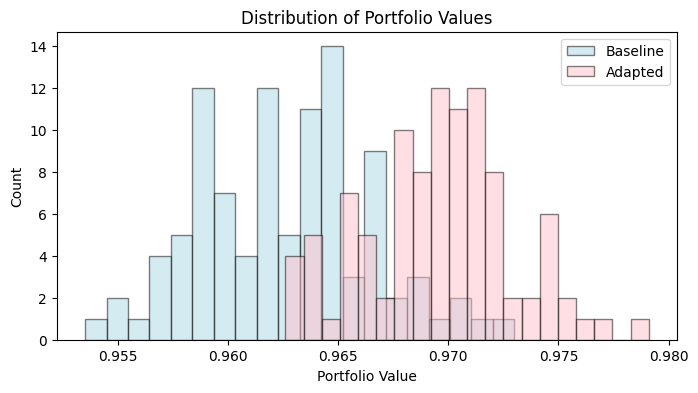

In [349]:
# Plot figures
fig, ax = plt.subplots(figsize=(8, 4))
# (PRISK)
ax.hist(baseline_pvs, bins=20, density=False, alpha=0.5, color='lightblue', edgecolor='black', label='Baseline')
ax.hist(adapted_pvs, bins=20, density=False, alpha=0.5, color='pink', edgecolor='black', label='Adapted')
ax.set_title("Distribution of Portfolio Values")
ax.set_xlabel("Portfolio Value")
ax.legend()
# ax.set_xlim(0.996, 1)
ax.set_ylabel("Count")

In [350]:
index = 0
print(s_baseline_pvs[index])
print(s_adapted_pvs[index])

0.935
0.9755


In [351]:
print('Baseline Average Impact:', np.mean(baseline_pvs))
print('Baseline VaR 99%:', np.quantile(baseline_pvs, 0.01))
print('Adapted Average Impact:', np.mean(adapted_pvs))
print('Adapted VaR 99%:', np.quantile(adapted_pvs, 0.01))

Baseline Average Impact: 0.962599
Baseline VaR 99%: 0.955183
Adapted Average Impact: 0.969544
Adapted VaR 99%: 0.963194


## Testing Area

In [352]:
# Function for running simulation but extracting PDs per firm
def simulation_run_with_firm_tracking(assets, damage_curves, leverage_ratios, Ins_Cap, n_sims, sigma, insured=False, adaptation=False):
    """
    Enhanced simulation that tracks Merton PDs by firm name
    
    Returns:
    --------
    portfolio_values : list
        Portfolio values for each simulation
    firm_pd_results : pd.DataFrame
        DataFrame with columns for each firm's PD across simulations
    firm_names : list
        List of firm names in order
    simulation_summary : dict
        Summary statistics for each firm
    """
    
    # Prepare simulation
    assets = assets.copy()
    if adaptation:
        assets.loc[:, "flood_protection"] = adaptation
    
    # Create continuous damage curves
    continuous_curves = convert_to_continous_damage(damage_curves)
    
    # Extract assets and firms
    firms, processed_assets = extract_firms(assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)
    
    # Get firm names for tracking
    firm_names = [firm.name for firm in firms]
    print(f"Tracking {len(firm_names)} firms: {firm_names}")
    
    # Construct portfolio
    portfolio = Portfolio("Simulation Portfolio")
    nav = 1
    for firm in firms:
        portfolio.add_position(firm, nav/(len(firms)*firm.npv))
    
    # Initialize storage for results
    np.random.seed(0)
    portfolio_values = []
    firm_pd_data = {name: [] for name in firm_names}  # Store PDs by firm name
    
    # Additional tracking for detailed analysis
    firm_metrics = {name: {'base_npv': [], 'post_sim_npv': [], 'leverage': [], 'damage_ratio': []} 
                   for name in firm_names}
    
    print(f"Running {n_sims} simulations...")
    
    for i in tqdm(range(n_sims)):
        # Reset and prepare assets
        assets_list = processed_assets.asset.to_list().copy()
        insurer = Insurance("Insurance company", capital=Ins_Cap, subscribers=[])
        kernel = Kernel(assets=assets_list, insurers=[insurer])
        
        # Store baseline values
        baseline_values = {firm.name: firm.npv for firm in firms}
        
        # Add insurance if specified
        for asset in assets_list:
            if insured:
                asset.add_insurer(insurer)
            FloodEntitySim(asset, model="exceedance_poisson").simulate(time_horizon=25, kernel=kernel)
        
        # Run simulation
        kernel.run(time_horizon=25, verbose=0)
        
        # Store portfolio value
        portfolio_values.append(portfolio.underlying_value)
        
        # Calculate Merton PDs for each firm and store by name
        for firm in firms:
            # Calculate change in PD (your current approach)
            base_pd = merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
            post_pd = merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)
            delta_pd = post_pd - base_pd
            
            # Store in firm-specific list
            firm_pd_data[firm.name].append(delta_pd)
            
            # Store additional metrics for analysis
            firm_metrics[firm.name]['base_npv'].append(firm.base_value)
            firm_metrics[firm.name]['post_sim_npv'].append(firm.npv)
            firm_metrics[firm.name]['leverage'].append(firm.leverage)
            
            # Calculate damage ratio
            total_damages = firm.total_replacement_costs + firm.total_business_disruption
            damage_ratio = total_damages / firm.base_value if firm.base_value > 0 else 0
            firm_metrics[firm.name]['damage_ratio'].append(damage_ratio)
        
        # Reset assets for next simulation
        for asset in assets_list:
            asset.reset()
    
    # Convert results to DataFrame for easy analysis
    firm_pd_df = pd.DataFrame(firm_pd_data)
    firm_pd_df.index.name = 'simulation'
    
    # Create summary statistics
    simulation_summary = {}
    for firm_name in firm_names:
        pds = firm_pd_data[firm_name]
        simulation_summary[firm_name] = {
            'mean_delta_pd': np.mean(pds),
            'std_delta_pd': np.std(pds),
            'max_delta_pd': np.max(pds),
            'min_delta_pd': np.min(pds),
            'q95_delta_pd': np.percentile(pds, 95),
            'q99_delta_pd': np.percentile(pds, 99),
            'prob_pd_increase': np.mean(np.array(pds) > 0),  # Probability PD increases
            'mean_damage_ratio': np.mean(firm_metrics[firm_name]['damage_ratio']),
            'mean_leverage': np.mean(firm_metrics[firm_name]['leverage'])
        }
    
    return portfolio_values, firm_pd_df, firm_names, simulation_summary, firm_metrics

def analyze_firm_default_risk(firm_pd_df, firm_names, simulation_summary, save_results=True):
    """
    Analyze and visualize firm-level default risk results
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    print("FIRM-LEVEL DEFAULT RISK ANALYSIS")
    print("=" * 50)
    
    # Print summary table
    summary_df = pd.DataFrame(simulation_summary).T
    print("\nSUMMARY STATISTICS (Delta PD):")
    print(summary_df[['mean_delta_pd', 'std_delta_pd', 'q95_delta_pd', 'prob_pd_increase']].round(4))
    
    # Identify highest risk firms
    highest_risk = summary_df['mean_delta_pd'].idxmax()
    most_volatile = summary_df['std_delta_pd'].idxmax()
    
    print(f"\nHIGHEST AVERAGE RISK: {highest_risk} (Δ PD = {summary_df.loc[highest_risk, 'mean_delta_pd']:.3%})")
    print(f"MOST VOLATILE RISK: {most_volatile} (Std = {summary_df.loc[most_volatile, 'std_delta_pd']:.3%})")
    
    # Create visualizations
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Distribution of Delta PD by Firm',
            'Probability of PD Increase',
            'Mean Delta PD vs Damage Ratio',
            'Delta PD Time Series (Sample)'
        ),
        specs=[[{"type": "box"}, {"type": "bar"}],
               [{"type": "scatter"}, {"type": "scatter"}]]
    )
    
    # Box plot of PD distributions
    for firm_name in firm_names:
        fig.add_trace(
            go.Box(y=firm_pd_df[firm_name] * 100, name=firm_name, showlegend=False),
            row=1, col=1
        )
    
    # Bar chart of probability of PD increase
    prob_increase = [simulation_summary[name]['prob_pd_increase'] for name in firm_names]
    fig.add_trace(
        go.Bar(x=firm_names, y=prob_increase, showlegend=False),
        row=1, col=2
    )
    
    # Scatter: Mean Delta PD vs Damage Ratio
    mean_delta_pds = [simulation_summary[name]['mean_delta_pd'] for name in firm_names]
    damage_ratios = [simulation_summary[name]['mean_damage_ratio'] for name in firm_names]
    
    fig.add_trace(
        go.Scatter(
            x=damage_ratios,
            y=[pd * 100 for pd in mean_delta_pds],
            mode='markers+text',
            text=firm_names,
            textposition="top center",
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Time series for first 100 simulations (sample)
    sample_sims = min(100, len(firm_pd_df))
    for firm_name in firm_names[:5]:  # Show only first 5 firms to avoid clutter
        fig.add_trace(
            go.Scatter(
                x=list(range(sample_sims)),
                y=firm_pd_df[firm_name][:sample_sims] * 100,
                mode='lines',
                name=firm_name
            ),
            row=2, col=2
        )
    
    # Update layout
    fig.update_layout(height=800, title_text="Firm-Level Default Risk Analysis")
    fig.update_yaxes(title_text="Delta PD (%)", row=1, col=1)
    fig.update_yaxes(title_text="Probability", row=1, col=2)
    fig.update_xaxes(title_text="Damage Ratio", row=2, col=1)
    fig.update_yaxes(title_text="Mean Delta PD (%)", row=2, col=1)
    fig.update_xaxes(title_text="Simulation", row=2, col=2)
    fig.update_yaxes(title_text="Delta PD (%)", row=2, col=2)
    
    fig.show()
    
    if save_results:
        # Save detailed results
        firm_pd_df.to_csv('firm_pd_results.csv')
        summary_df.to_csv('firm_summary_stats.csv')
        print("\nResults saved to 'firm_pd_results.csv' and 'firm_summary_stats.csv'")
    
    return summary_df

def get_firm_risk_ranking(simulation_summary):
    """
    Rank firms by various risk metrics
    """
    print("\nFIRM RISK RANKINGS:")
    print("=" * 20)
    
    summary_df = pd.DataFrame(simulation_summary).T
    
    # Rank by mean delta PD
    mean_ranking = summary_df.sort_values('mean_delta_pd', ascending=False)
    print("\nBy Mean Delta PD:")
    for i, (firm, row) in enumerate(mean_ranking.head().iterrows(), 1):
        print(f"{i}. {firm}: {row['mean_delta_pd']:.3%}")
    
    # Rank by 99th percentile (tail risk)
    tail_ranking = summary_df.sort_values('q99_delta_pd', ascending=False)
    print("\nBy 99th Percentile Delta PD (Tail Risk):")
    for i, (firm, row) in enumerate(tail_ranking.head().iterrows(), 1):
        print(f"{i}. {firm}: {row['q99_delta_pd']:.3%}")
    
    # Rank by probability of PD increase
    prob_ranking = summary_df.sort_values('prob_pd_increase', ascending=False)
    print("\nBy Probability of PD Increase:")
    for i, (firm, row) in enumerate(prob_ranking.head().iterrows(), 1):
        print(f"{i}. {firm}: {row['prob_pd_increase']:.1%}")

In [353]:
portfolio_vals, firm_pds, firm_names, summary, metrics = simulation_run_with_firm_tracking(
    assets=thailand_assets,
    damage_curves=damage_curves,
    leverage_ratios=leverage_ratios,
    Ins_Cap=2e9,
    n_sims=1000,
    sigma=0.3,
    insured=False
)

Tracking 60 firms: ['Thai Holdings 001', 'Thai Holdings 002', 'Thai Holdings 003', 'Thai Holdings 005', 'Thai Holdings 006', 'Thai Holdings 007', 'Thai Holdings 011', 'Thai Holdings 012', 'Thai Holdings 013', 'Thai Holdings 014', 'Thai Holdings 015', 'Thai Holdings 016', 'Thai Holdings 017', 'Thai Holdings 018', 'Thai Holdings 019', 'Thai Holdings 020', 'Thai Holdings 021', 'Thai Holdings 022', 'Thai Holdings 023', 'Thai Holdings 024', 'Thai Holdings 025', 'Thai Holdings 027', 'Thai Holdings 028', 'Thai Holdings 029', 'Thai Holdings 030', 'Thai Holdings 031', 'Thai Holdings 032', 'Thai Holdings 033', 'Thai Holdings 034', 'Thai Holdings 035', 'Thai Holdings 036', 'Thai Holdings 037', 'Thai Holdings 041', 'Thai Holdings 042', 'Thai Holdings 043', 'Thai Holdings 044', 'Thai Holdings 045', 'Thai Holdings 046', 'Thai Holdings 047', 'Thai Holdings 048', 'Thai Holdings 049', 'Thai Holdings 050', 'Thai Holdings 051', 'Thai Holdings 052', 'Thai Holdings 053', 'Thai Holdings 054', 'Thai Holdings

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:57<00:00,  1.38s/it]


FIRM-LEVEL DEFAULT RISK ANALYSIS

SUMMARY STATISTICS (Delta PD):
                   mean_delta_pd  std_delta_pd  q95_delta_pd  prob_pd_increase
Thai Holdings 001         0.0000        0.0000        0.0000             0.996
Thai Holdings 002         0.0018        0.0016        0.0049             1.000
Thai Holdings 003         0.0001        0.0001        0.0003             0.996
Thai Holdings 005         0.0000        0.0000        0.0000             1.000
Thai Holdings 006         0.0030        0.0024        0.0075             0.982
Thai Holdings 007         0.0000        0.0000        0.0000             1.000
Thai Holdings 011         0.0037        0.0070        0.0130             1.000
Thai Holdings 012         0.0025        0.0023        0.0069             0.923
Thai Holdings 013         0.0026        0.0019        0.0063             1.000
Thai Holdings 014         0.0007        0.0004        0.0015             0.995
Thai Holdings 015         0.0000        0.0000        0.0000      

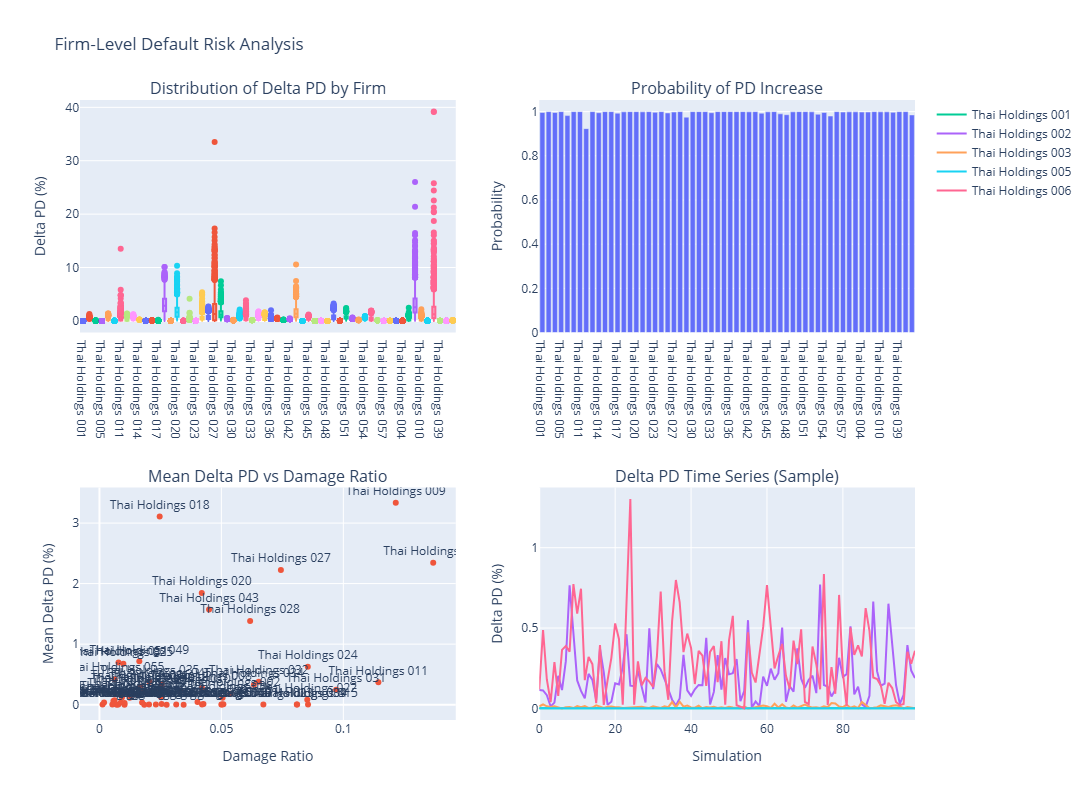


Results saved to 'firm_pd_results.csv' and 'firm_summary_stats.csv'


In [354]:
# Analyze results
summary_df = analyze_firm_default_risk(firm_pds, firm_names, summary)

In [355]:
# Get risk rankings
get_firm_risk_ranking(summary)


FIRM RISK RANKINGS:

By Mean Delta PD:
1. Thai Holdings 009: 3.334%
2. Thai Holdings 018: 3.107%
3. Thai Holdings 038: 2.345%
4. Thai Holdings 027: 2.224%
5. Thai Holdings 020: 1.844%

By 99th Percentile Delta PD (Tail Risk):
1. Thai Holdings 038: 16.054%
2. Thai Holdings 027: 13.305%
3. Thai Holdings 009: 13.053%
4. Thai Holdings 018: 8.364%
5. Thai Holdings 020: 6.692%

By Probability of PD Increase:
1. Thai Holdings 002: 100.0%
2. Thai Holdings 005: 100.0%
3. Thai Holdings 011: 100.0%
4. Thai Holdings 007: 100.0%
5. Thai Holdings 016: 100.0%


In [356]:
# Run for adapted
portfolio_vals, firm_pds, firm_names, summary, metrics = simulation_run_with_firm_tracking(
    assets=thailand_assets,
    damage_curves=damage_curves,
    leverage_ratios=leverage_ratios,
    Ins_Cap=2e9,
    n_sims=1000,
    sigma=0.3,
    insured=False,
    adaptation=50
)

Tracking 60 firms: ['Thai Holdings 001', 'Thai Holdings 002', 'Thai Holdings 003', 'Thai Holdings 005', 'Thai Holdings 006', 'Thai Holdings 007', 'Thai Holdings 011', 'Thai Holdings 012', 'Thai Holdings 013', 'Thai Holdings 014', 'Thai Holdings 015', 'Thai Holdings 016', 'Thai Holdings 017', 'Thai Holdings 018', 'Thai Holdings 019', 'Thai Holdings 020', 'Thai Holdings 021', 'Thai Holdings 022', 'Thai Holdings 023', 'Thai Holdings 024', 'Thai Holdings 025', 'Thai Holdings 027', 'Thai Holdings 028', 'Thai Holdings 029', 'Thai Holdings 030', 'Thai Holdings 031', 'Thai Holdings 032', 'Thai Holdings 033', 'Thai Holdings 034', 'Thai Holdings 035', 'Thai Holdings 036', 'Thai Holdings 037', 'Thai Holdings 041', 'Thai Holdings 042', 'Thai Holdings 043', 'Thai Holdings 044', 'Thai Holdings 045', 'Thai Holdings 046', 'Thai Holdings 047', 'Thai Holdings 048', 'Thai Holdings 049', 'Thai Holdings 050', 'Thai Holdings 051', 'Thai Holdings 052', 'Thai Holdings 053', 'Thai Holdings 054', 'Thai Holdings

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:53<00:00,  1.19s/it]


FIRM-LEVEL DEFAULT RISK ANALYSIS

SUMMARY STATISTICS (Delta PD):
                   mean_delta_pd  std_delta_pd  q95_delta_pd  prob_pd_increase
Thai Holdings 001         0.0000        0.0000        0.0000             0.918
Thai Holdings 002         0.0007        0.0007        0.0021             0.974
Thai Holdings 003         0.0000        0.0000        0.0001             0.879
Thai Holdings 005         0.0000        0.0000        0.0000             0.974
Thai Holdings 006         0.0019        0.0020        0.0058             0.863
Thai Holdings 007         0.0000        0.0000        0.0000             0.969
Thai Holdings 011         0.0007        0.0014        0.0026             0.988
Thai Holdings 012         0.0010        0.0015        0.0041             0.780
Thai Holdings 013         0.0008        0.0010        0.0028             0.996
Thai Holdings 014         0.0003        0.0003        0.0008             0.872
Thai Holdings 015         0.0000        0.0000        0.0000      

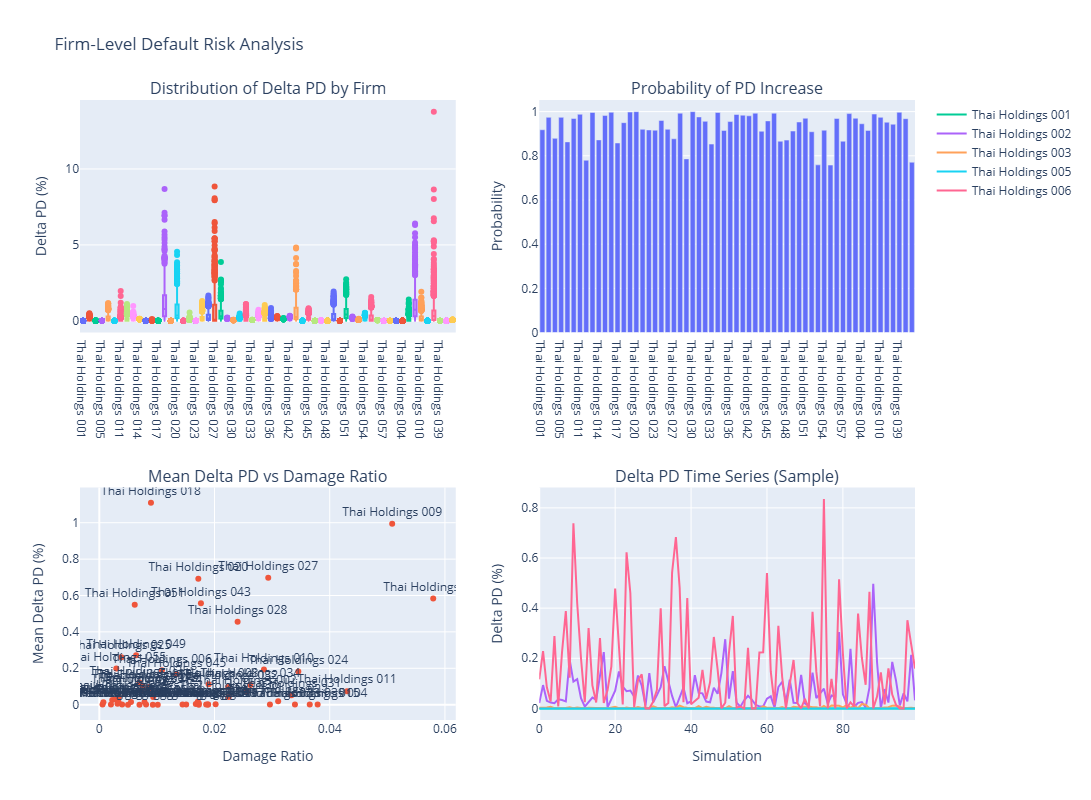


Results saved to 'firm_pd_results.csv' and 'firm_summary_stats.csv'


In [357]:
# Analyze results
summary_df = analyze_firm_default_risk(firm_pds, firm_names, summary)

In [358]:
# Get risk rankings
get_firm_risk_ranking(summary)


FIRM RISK RANKINGS:

By Mean Delta PD:
1. Thai Holdings 018: 1.109%
2. Thai Holdings 009: 0.994%
3. Thai Holdings 027: 0.697%
4. Thai Holdings 020: 0.692%
5. Thai Holdings 038: 0.584%

By 99th Percentile Delta PD (Tail Risk):
1. Thai Holdings 027: 5.416%
2. Thai Holdings 018: 4.904%
3. Thai Holdings 009: 4.517%
4. Thai Holdings 038: 4.411%
5. Thai Holdings 020: 3.266%

By Probability of PD Increase:
1. Thai Holdings 030: 100.0%
2. Thai Holdings 020: 100.0%
3. Thai Holdings 019: 99.8%
4. Thai Holdings 016: 99.7%
5. Thai Holdings 039: 99.7%


## OLD SCRATCH STUFF

In [ ]:
# continuous_curves = convert_to_continous_damage(damage_curves)
# firms, processed_assets = extract_firms(thailand_assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)

# # Construct portfolio
# portfolio = Portfolio("Thailand Assets")
# nav = 1 
# for firm in firms:
#     portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

# hybas_basins = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/hybas_as_lev06_v1c.shp"
# basin_outlet_file = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/lev06_outlets_final_clipped_Thailand_no_duplicates.csv"

# flood_protection = 100
# insured = False
# insurer_capital = 2e9
# simulations = 100
# country = "Thailand"
# random_seed = 0
# sigma=0.2

# asset_run = thailand_assets.copy()
# if flood_protection:
#     asset_run.loc[:, "flood_protection"] = asset_run[flood_protection]

# continuous_curves = convert_to_continous_damage(damage_curves)
# firms, processed_assets = extract_firms(asset_run, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)

# # Construct portfolio
# portfolio = Portfolio("Thailand Assets")
# nav = 1 
# for firm in firms:
#     portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

# # Complete Independence
# np.random.seed(0)
# portfolio_values = []
# merton_independence = []
# for i in tqdm(range(simulations)):
#     assets = processed_assets.asset.to_list().copy()
#     insurer = Insurance("Insurance company", capital=insurer_capital, subscribers=[])
#     kernel = Kernel(assets=assets, insurers=[insurer])
#     for asset in assets:
#         if insured:
#             asset.add_insurer(insurer)
#         # The flood entity sim simulates floods at the asset-level without considering other asset events
#         FloodEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
#     kernel.run(time_horizon=25, verbose=0) # time horizon: 25 years, the remainder will be included in TV
#     portfolio_values.append(portfolio.underlying_value)
#     merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
#                     + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
#                 for firm in firms]
#     merton_independence.append(merton_pds)
#     for asset in assets:
#         asset.reset() # Reset the assets to their initial state

# merton_avg = [np.mean(mert) for mert in merton_independence]